In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("C:\\Users\\syeon\\Desktop\\data\\train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [4]:
test = pd.read_csv("C:\\Users\\syeon\\Desktop\\data\\test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

### Feature Engineering

In [5]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 16)

In [6]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 13)

In [7]:
# 연속형 feature ["temp","humidity","windspeed","atemp"]를 범주형으로 변경
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [8]:
feature_names =['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'hour', 'dayofweek', 'holiday', 'workingday']

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [9]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,0.0,2011,0,5,0,0
1,1,1,9.02,13.635,80,0.0,2011,1,5,0,0
2,1,1,9.02,13.635,80,0.0,2011,2,5,0,0
3,1,1,9.84,14.395,75,0.0,2011,3,5,0,0
4,1,1,9.84,14.395,75,0.0,2011,4,5,0,0


In [10]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [11]:
label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [12]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이 배열
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워줌
    log_predict = np.log(predicted_values +1)
    log_actual = np.log(actual_values +1)
    
    # ↑ 값에서 실제값을 빼주고 제곱
    difference = (log_predict - log_actual) **2
    
    # 평균
    mean_difference = difference.mean()
    
    # 루트
    score = np.sqrt(mean_difference)
    
    return score

### 선형회귀 모델

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
IModel = LinearRegression()

# 모델 학습
y_train_log = np.log1p(y_train)
IModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가
preds = IModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds)))

RMSLE Value For Linear Regression:  0.9796533446288508


### 릿지

In [23]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds)))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9796533426169097


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013231,0.002274,0.003081,0.002917,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-0.269724,-0.207771,-0.253418,-0.222550,-0.207610,-0.232215,0.025111,1
1,0.007361,0.008632,0.003129,0.006257,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-0.269726,-0.207772,-0.253418,-0.222550,-0.207609,-0.232215,0.025111,2
2,0.007432,0.009294,0.003675,0.006076,1,3000,"{'alpha': 1, 'max_iter': 3000}",-0.269737,-0.207776,-0.253416,-0.222546,-0.207605,-0.232216,0.025115,3
3,0.013572,0.006845,0.003546,0.007092,2,3000,"{'alpha': 2, 'max_iter': 3000}",-0.269750,-0.207781,-0.253415,-0.222542,-0.207601,-0.232218,0.025119,4
4,0.003337,0.006187,0.003607,0.006652,3,3000,"{'alpha': 3, 'max_iter': 3000}",-0.269763,-0.207787,-0.253413,-0.222538,-0.207597,-0.232220,0.025122,5


In [24]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.232215
1,0.10,0.232215
2,1.00,0.232216
3,2.00,0.232218
4,3.00,0.232220


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

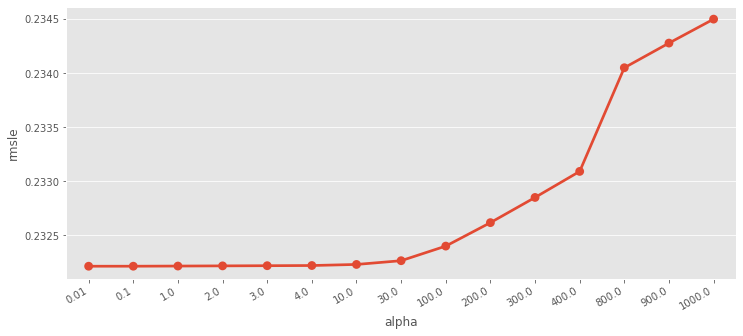

In [25]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### 라쏘
-> Feature 선택이 자동으로 이루어짐

In [27]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds)))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.979666495191101


,alpha,rmsle
0,10.000000,0.317347
1,1.000000,0.251975
2,0.500000,0.247863
3,0.333333,0.246753
4,0.250000,0.246264


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

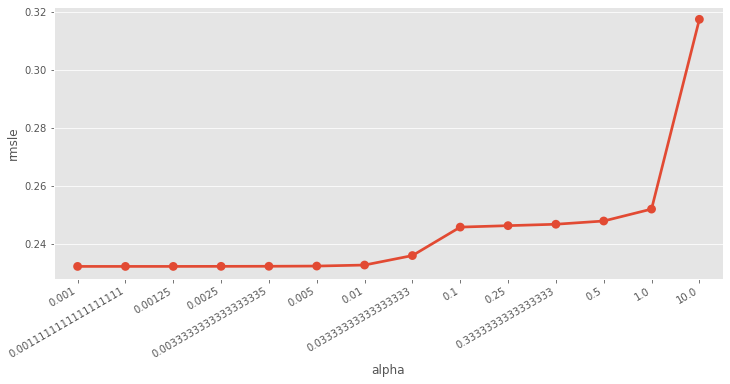

In [28]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### 앙상블 - Gradient Boost

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds))
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.20417262895601526


<AxesSubplot:ylabel='Density'>

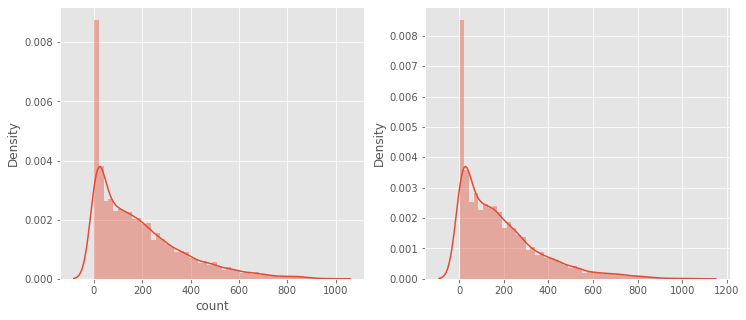

In [31]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

### 제출

In [32]:
submission = pd.read_csv("C:\\Users\\syeon\\Desktop\\data\\sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.449853
1,2011-01-20 01:00:00,5.658840
2,2011-01-20 02:00:00,3.825399
3,2011-01-20 03:00:00,2.586785
4,2011-01-20 04:00:00,2.281436


In [33]:
submission.to_csv(f"C:\\Users\\syeon\\Desktop\\data\\Score_{score:.5f}_submission.csv", index=False)